In [1]:
import torch, torchvision

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import method
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets

%matplotlib inline

In [4]:
from tqdm import tqdm

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

In [6]:
import os
from PIL import Image

valdir = './imnet/'
filenames = os.listdir(valdir)
batch_size = 64
img_batch = []
for fn in filenames[:batch_size]:
    img = Image.open(valdir + fn)
    img = transform(img)
    img = normalize(img)
    img_batch.append(img.numpy())

img_batch = np.array(img_batch)

In [7]:
img_batch.shape

(64, 3, 224, 224)

In [8]:
"""from skimage.io import imread
from skimage.transform import resize
import os

img_batch = []
images = os.listdir('./imnet')

for path in tqdm(images[:64]):
    try:
        img = imread('./imnet/'+path).transpose((2, 0, 1))
        img = resize(img, (3, 224, 224)).astype(float)
        img_batch.append(transform(img.copy()))
    except:
        pass

img_batch_64 = np.array(img_batch)"""

"from skimage.io import imread\nfrom skimage.transform import resize\nimport os\n\nimg_batch = []\nimages = os.listdir('./imnet')\n\nfor path in tqdm(images[:64]):\n    try:\n        img = imread('./imnet/'+path).transpose((2, 0, 1))\n        img = resize(img, (3, 224, 224)).astype(float)\n        img_batch.append(transform(img.copy()))\n    except:\n        pass\n\nimg_batch_64 = np.array(img_batch)"

In [9]:
"""mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def transform(img):
    img -= mean[:, None, None]
    img /= std[:, None, None]
    return img"""

'mean = np.array([0.485, 0.456, 0.406])\nstd = np.array([0.229, 0.224, 0.225])\ndef transform(img):\n    img -= mean[:, None, None]\n    img /= std[:, None, None]\n    return img'

In [8]:
def iterate_minibatches(inputs, adv, batchsize=100):
    #make transform
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        excerpt = slice(start_idx, start_idx + batchsize)
        cur_batch = []
        cur_batch_pert = []
        for path in inputs[excerpt]:
            cur_img = Image.open('./imnet/'+path)
            if np.array(cur_img).ndim != 3 or np.array(cur_img).shape[-1] != 3:
                continue
            cur_img = transform(cur_img)
            cur_img_pert = torch.FloatTensor(np.copy(cur_img.numpy() + adv))
            
            cur_img = normalize(cur_img)
            cur_img_pert = normalize(cur_img_pert)
            cur_batch.append(cur_img)
            cur_batch_pert.append(cur_img_pert)
        yield cur_batch, cur_batch_pert

In [47]:
def fooling_rate(net, images, adv, start=64):
    fooling_rate = []
    num_pics = 0
    for cur_batch, cur_batch_pert in iterate_minibatches(images[start:], adv):
        img_batch_tensor = torch.stack(cur_batch).to(d)
        p = method.tonp(net(img_batch_tensor))
        img_batch_pert_tensor = torch.stack(cur_batch_pert).to(d)
        p_pert = method.tonp(net(img_batch_pert_tensor))

        fooling_rate.append(np.sum(p.argmax(1) != p_pert.argmax(1)))
        num_pics += p.shape[0]
    return np.sum(fooling_rate)*100./num_pics

In [12]:
#d = torch.device('cuda')
#net = torchvision.models.vgg16(pretrained=True)
#net.to(d);
#net.eval()
#model = method.VGGWrapper(net, d)

In [10]:
img_batch.shape

(64, 3, 224, 224)

In [11]:
def get_permutation(model, img_batch, layer, p=np.inf, q=10):
    x = torch.randn(3 * 224**2, requires_grad=True).to(d)
    x_img = x.reshape((1, 3, 224, 224))
    n = model.feature(x_img, layer).shape[0]
    Adot, ATdot = method.get_batched_matvec(img_batch, model, layer, n)
    x0 = (np.random.rand(3 * 224**2) - 0.5)/255.
    x0 = x0.astype(dtype=np.float64)
    x, s = method.power_method(x0, Adot, ATdot, p, q, max_iter=10)
    return x, s

## VGG16

In [15]:
d = torch.device('cuda')
net = torchvision.models.vgg16(pretrained=True)
net.to(d)
net.eval()
model = method.VGGWrapper(net, d)

In [16]:
layers = {"block2_pool" : 10,
        "block3_conv1" : 12,
        "block3_conv2" :  14,
        "block3_conv3" : 16}

In [17]:
#! mkdir perts3

In [12]:
images = os.listdir('./imnet')

In [19]:
singular_values = []
fooling_rates = []
for layer in layers:
    print(layer)
    x, s = get_permutation(model, img_batch, layers[layer], p=np.inf, q=10)
    singular_values.append(s)
    print("singular value", s)
    adv = x.reshape(3, 224, 224) * 0.04
    #np.save('perts3/vgg16_' + layer +'.npy', adv)
    fooling_rates.append(fooling_rate(net, images, adv))
    print("fooling rate", fooling_rates[-1])

block2_pool


  0%|          | 0/499 [00:00<?, ?it/s]

singular value 1567.2365069620992


100%|██████████| 499/499 [13:11<00:00,  1.58s/it]


fooling rate 55.989551446879716
block3_conv1


  0%|          | 0/499 [00:00<?, ?it/s]

singular value 2446.8331470077164


100%|██████████| 499/499 [12:54<00:00,  1.91s/it]


fooling rate 43.296191992163585
block3_conv2


  0%|          | 0/499 [00:00<?, ?it/s]

singular value 5056.807371744894


100%|██████████| 499/499 [15:51<00:00,  1.96s/it]


fooling rate 46.80421207297661
block3_conv3


100%|██████████| 499/499 [15:44<00:00,  1.87s/it]

fooling rate 44.310436308722096


block2_pool fooling rate:  55.99 singular value:  1567.24
block3_conv1 fooling rate:  43.3 singular value:  2446.83
block3_conv2 fooling rate:  46.8 singular value:  5056.81
block3_conv3 fooling rate:  44.31 singular value:  8585.74


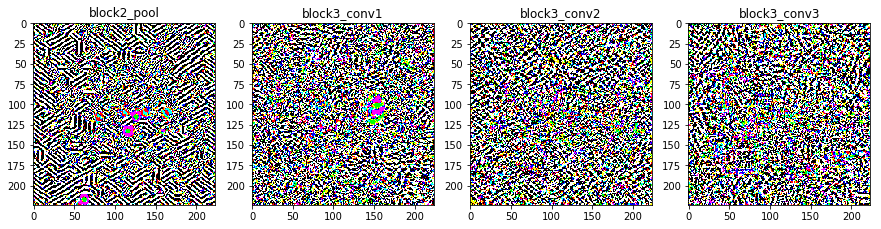

In [35]:
for i, layer in enumerate(layers):
    print(layer, "fooling rate: ", np.round(fooling_rates[i], 2), "singular value: ",  np.round(singular_values[i], 2))
plt.figure(figsize=(15, 8))
for i, layer in enumerate(layers):
    perm = np.load('perts3/vgg16_' + layer +'.npy')
    adv1 = (perm - perm.min())/(perm.max() - perm.min())
    plt.subplot(1, 4, i+1)
    plt.title(layer)
    plt.imshow(adv1.transpose((1, 2, 0)))
plt.savefig("exp_figs/vgg16.png")

## VGG19

In [22]:
net = torchvision.models.vgg19(pretrained=True)
net.to(d);
net.eval()
model = method.VGGWrapper(net, d)

In [32]:
layers = {"block2_pool" : 10,
        "block3_conv1" : 12,
        "block3_conv2" :  14,
        "block3_conv3" : 16}

In [24]:
singular_values_19 = []
fooling_rates_19 = []
for layer in layers:
    print(layer, end=" ")
    x, s = get_permutation(model, img_batch, layers[layer], p=np.inf, q=10)
    singular_values_19.append(s)
    print("singular value", s, end=" ")
    adv = x.reshape(3, 224, 224) * 0.04
    np.save('perts3/vgg19_' + layer +'.npy', adv)
    fooling_rates_19.append(fooling_rate(net, images, adv))
    print("fooling rate", fooling_rates_19[-1])

block2_pool 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 1630.6077822742202 

100%|██████████| 499/499 [17:22<00:00,  2.28s/it]


fooling rate 55.94873678625362
block3_conv1 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 2415.3277002743384 

100%|██████████| 499/499 [16:00<00:00,  1.74s/it]


fooling rate 44.39002489694298
block3_conv2 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 5044.295675011829 

100%|██████████| 499/499 [16:04<00:00,  1.63s/it]


fooling rate 47.25317333986368
block3_conv3 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 10517.26479674731 

100%|██████████| 499/499 [13:57<00:00,  1.63s/it]

fooling rate 45.69405330394678


block2_pool fooling rate:  55.95 singular value:  1630.61
block3_conv1 fooling rate:  44.39 singular value:  2415.33
block3_conv2 fooling rate:  47.25 singular value:  5044.3
block3_conv3 fooling rate:  45.69 singular value:  10517.26


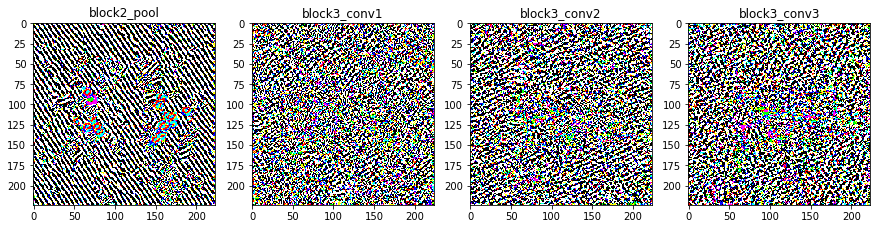

In [34]:
for i, layer in enumerate(layers):
    print(layer, "fooling rate: ", np.round(fooling_rates_19[i], 2), "singular value: ",  \
          np.round(singular_values_19[i], 2))
plt.figure(figsize=(15, 8))
for i, layer in enumerate(layers):
    perm = np.load('perts3/vgg19_' + layer +'.npy')
    adv1 = (perm - perm.min())/(perm.max() - perm.min())
    plt.subplot(1, 4, i+1)
    plt.title(layer)
    plt.imshow(adv1.transpose((1, 2, 0)))
plt.savefig("exp_figs/vgg19.png")

## ResNet

In [14]:
d = torch.device('cuda')
net = torchvision.models.resnet50(pretrained=True)
net.to(d);
net.eval()
model = method.ResNetWrapper(net, d)

In [15]:
model.layers[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [16]:
layers = {
    "conv1" : 1,
    "bottleneck_1" : 5,
    "bottleneck_2" : 6,
    "bottleneck_3" : 7}

In [17]:
singular_values_res = []
fooling_rates_res = []
for layer in layers:
    print(layer, end=" ")
    x, s = get_permutation(model, img_batch, layers[layer], p=np.inf, q=10)
    singular_values_res.append(s)
    print("singular value", s, end=" ")
    adv = x.reshape(3, 224, 224) * 0.04
    np.save('perts3/resnet50_' + layer +'.npy', adv)
    fooling_rates_res.append(fooling_rate(net, images, adv))
    print("fooling rate", fooling_rates_res[-1])

conv1 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 61.10815911379694 

100%|██████████| 499/499 [11:18<00:00,  1.33s/it]


fooling rate 47.32868046202196
bottleneck_1 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 43.40467847894296 

100%|██████████| 499/499 [11:12<00:00,  1.34s/it]


fooling rate 34.75980572221542
bottleneck_2 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 117.3420032551573 

100%|██████████| 499/499 [13:51<00:00,  1.98s/it]


fooling rate 33.67209501652994
bottleneck_3 

  0%|          | 0/499 [00:00<?, ?it/s]

singular value 669.2393459508683 

100%|██████████| 499/499 [15:14<00:00,  1.97s/it]

fooling rate 29.43961470960369


conv1 fooling rate:  47.33 singular value:  61.11
bottleneck_1 fooling rate:  34.76 singular value:  43.4
bottleneck_2 fooling rate:  33.67 singular value:  117.34
bottleneck_3 fooling rate:  29.44 singular value:  669.24


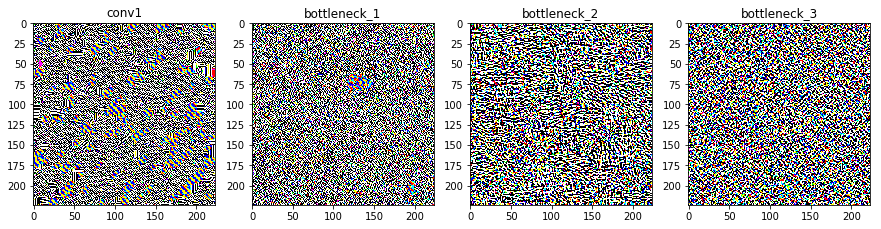

In [19]:
for i, layer in enumerate(layers):
    print(layer, "fooling rate: ", np.round(fooling_rates_res[i], 2), "singular value: ",  \
          np.round(singular_values_res[i], 2))
plt.figure(figsize=(15, 8))
for i, layer in enumerate(layers):
    perm = np.load('perts3/resnet50_' + layer +'.npy')
    adv1 = (perm - perm.min())/(perm.max() - perm.min())
    plt.subplot(1, 4, i+1)
    plt.title(layer)
    plt.imshow(adv1.transpose((1, 2, 0)))
plt.savefig("exp_figs/resnet50.png")

## Generalization

In [20]:
net = torchvision.models.vgg19(pretrained=True)
net.to(d);
net.eval()
model = method.VGGWrapper(net, d)

In [21]:
adv = np.load('perts3/vgg16_block2_pool.npy')
r = fooling_rate(net, images, adv)
print("vgg16", np.round(r, 2))
adv = np.load('perts3/resnet50_conv1.npy')
r_res = fooling_rate(net, images, adv)
print("resnet50", np.round(r_res, 2))

  0%|          | 0/499 [00:00<?, ?it/s]

vgg16 57.36


100%|██████████| 499/499 [14:10<00:00,  1.73s/it]

resnet50 56.37


In [22]:
net = torchvision.models.vgg16(pretrained=True)
net.to(d);
net.eval()
model = method.VGGWrapper(net, d)

In [23]:
adv = np.load('perts3/vgg19_block2_pool.npy')
r = fooling_rate(net, images, adv)
print("vgg19", np.round(r, 2))
adv = np.load('perts3/resnet50_conv1.npy')
r_res = fooling_rate(net, images, adv)
print("resnet50", np.round(r_res, 2))

  0%|          | 0/499 [00:00<?, ?it/s]

vgg19 58.04


100%|██████████| 499/499 [13:26<00:00,  1.60s/it]

resnet50 62.15


In [24]:
net = torchvision.models.resnet50(pretrained=True)
net.to(d);
net.eval()
model = method.ResNetWrapper(net, d)

In [25]:
adv = np.load('perts3/vgg16_block2_pool.npy')
r = fooling_rate(net, images, adv)
print("vgg16", np.round(r, 2))
adv = np.load('perts3/vgg19_block2_pool.npy')
r = fooling_rate(net, images, adv)
print("vgg19", np.round(r, 2))

  0%|          | 0/499 [00:00<?, ?it/s]

vgg16 37.3


100%|██████████| 499/499 [11:37<00:00,  1.29s/it]

vgg19 36.65


## Batch size

In [26]:
net = torchvision.models.vgg19(pretrained=True)
net.to(d);
net.eval()
model = method.VGGWrapper(net, d)

In [44]:
import os
from PIL import Image

valdir = './imnet/'
filenames = os.listdir(valdir)
batch_size = 100
img_batch = []
for fn in filenames[:batch_size]:
    img = Image.open(valdir + fn)
    img = transform(img)
    img = normalize(img)
    img_batch.append(img.numpy())

img_batch = np.array(img_batch)

In [ ]:
batch_size = np.linspace(5, 100, 6)
fooling_rates_bs2 = []
for bs in batch_size:
    print(int(bs))
    x, s = get_permutation(model, img_batch[:int(bs)], 10, p=np.inf, q=10)
    adv = x.reshape(3, 224, 224) * 0.04
    fooling_rates_bs2.append(fooling_rate(net, images, adv, start=int(bs)))
    print("fooling rate", fooling_rates_bs2[-1])

5


100%|██████████| 499/499 [14:14<00:00,  1.63s/it]


fooling rate 42.28579590670721
24


100%|██████████| 499/499 [14:32<00:00,  2.11s/it]


fooling rate 55.097335020201605
43


100%|██████████| 499/499 [18:54<00:00,  2.05s/it]


fooling rate 55.84736251402918
62


100%|██████████| 499/499 [14:32<00:00,  1.62s/it]


fooling rate 55.62426023427615
81


 28%|██▊       | 138/499 [03:54<09:30,  1.58s/it]

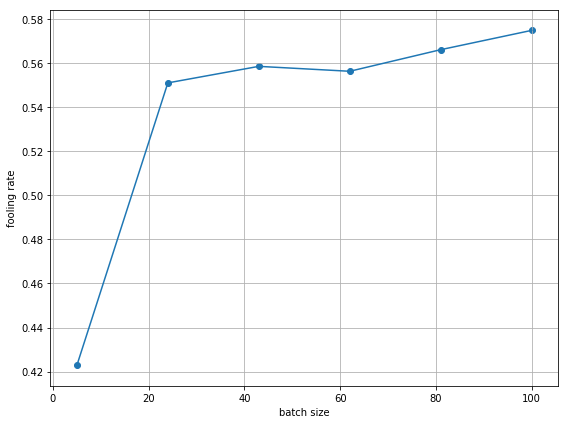

In [51]:
plt.figure(figsize=(8, 6))
bs = list(map(int, list(batch_size)))
plt.plot(bs, np.array(fooling_rates_bs2)/100)
plt.scatter(bs, np.array(fooling_rates_bs2)/100)
plt.grid()
plt.xlabel("batch size")
plt.ylabel("fooling rate")
plt.tight_layout()
plt.savefig("exp_figs/bs.png")

## Layer

In [38]:
net = torchvision.models.vgg19(pretrained=True)
net.to(d);
net.eval()
model = method.VGGWrapper(net, d)

In [39]:
len(model.layers)

37

In [42]:
fooling_rates_layers = []
for layer in range(1, 15):
    print(layer)
    x, s = get_permutation(model, img_batch, layer, p=np.inf, q=10)
    adv = x.reshape(3, 224, 224) * 0.04
    fooling_rates_layers.append(fooling_rate(net, images, adv))
    print("fooling rate", fooling_rates_layers[-1])

1


100%|██████████| 19/19 [00:31<00:00,  1.60s/it]


fooling rate 41.751746372917786
2


100%|██████████| 19/19 [00:32<00:00,  1.71s/it]


fooling rate 41.859215475550776
3


100%|██████████| 19/19 [00:31<00:00,  1.54s/it]


fooling rate 72.16550241805481
4


100%|██████████| 19/19 [00:32<00:00,  1.60s/it]


fooling rate 72.64911337990328
5


100%|██████████| 19/19 [00:30<00:00,  1.57s/it]


fooling rate 74.42235357334766
6


100%|██████████| 19/19 [00:32<00:00,  1.63s/it]


fooling rate 43.417517463729176
7


100%|██████████| 19/19 [00:31<00:00,  1.62s/it]


fooling rate 41.160666308436326
8


100%|██████████| 19/19 [00:32<00:00,  1.62s/it]


fooling rate 60.98871574422353
9


100%|██████████| 19/19 [00:31<00:00,  1.58s/it]


fooling rate 61.20365394948952
10


100%|██████████| 19/19 [00:31<00:00,  1.70s/it]


fooling rate 56.63621708758732
11


100%|██████████| 19/19 [00:32<00:00,  1.69s/it]


fooling rate 48.25362708221386
12


100%|██████████| 19/19 [00:31<00:00,  1.63s/it]


fooling rate 46.37291778613648
13


100%|██████████| 19/19 [00:31<00:00,  1.57s/it]


fooling rate 48.03868887694788
14


100%|██████████| 19/19 [00:32<00:00,  1.65s/it]

fooling rate 47.608812466415905


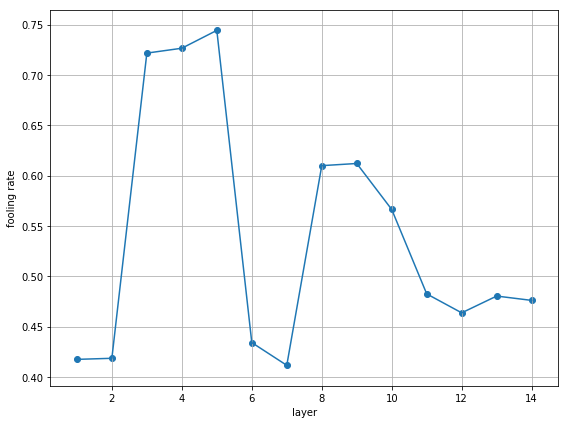

In [43]:
plt.figure(figsize=(8, 6))

plt.plot([i for i in range(1, 15)], np.array(fooling_rates_layers)/100)
plt.scatter([i for i in range(1, 15)], np.array(fooling_rates_layers)/100)
plt.grid()
plt.xlabel("layer")
plt.ylabel("fooling rate")
plt.tight_layout()
plt.savefig("exp_figs/layers.png")